# Exercise 3

## Imports

In [1]:
# !pip install scikit-learn

In [2]:
import time
import os
import optuna
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import log_loss
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score

In [3]:
is_run_on_colab = False
if is_run_on_colab:
    from google.colab import drive
    drive.mount('/content/drive')

In [4]:
plt.style.use('seaborn-v0_8-pastel')

In [5]:
import sklearn

In [6]:
sklearn.__version__

'1.2.1'

## Data loading

In [7]:
ag_news_train_df = pd.read_csv('data/ag_news_train.csv')
ag_news_test_df = pd.read_csv('data/ag_news_test.csv')
amazon_reviews_df = pd.read_csv('data/cleaned_amazon_reviews.csv')

In [8]:
ag_news_train_df.shape

(120000, 3)

In [9]:
ag_news_test_df.shape

(7600, 3)

In [10]:
ag_news_train_df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [11]:
amazon_reviews_df.shape

(17340, 4)

In [12]:
amazon_reviews_df.head()

,sentiments,cleaned_review,cleaned_review_length,review_score
0,positive,i wish would have gotten one earlier love it a...,19,5.0
1,neutral,i ve learned this lesson again open the packag...,88,1.0
2,neutral,it is so slow and lags find better option,9,2.0
3,neutral,roller ball stopped working within months of m...,12,1.0
4,neutral,i like the color and size but it few days out ...,21,1.0


In [13]:
amazon_reviews_df.isna().sum()

sentiments               0
cleaned_review           3
cleaned_review_length    0
review_score             0
dtype: int64

<AxesSubplot: >

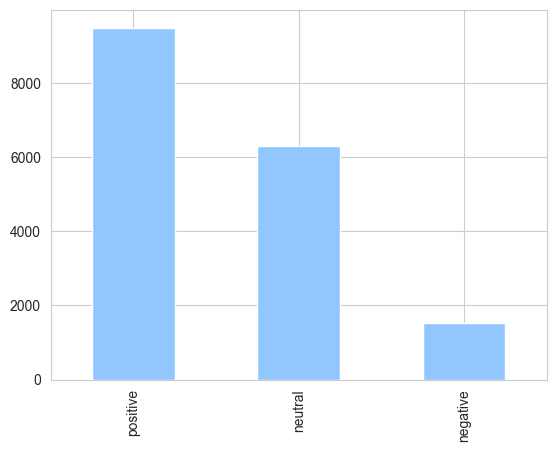

In [14]:
amazon_reviews_df.sentiments.value_counts().plot(kind='bar')

Unbalanced target

<AxesSubplot: >

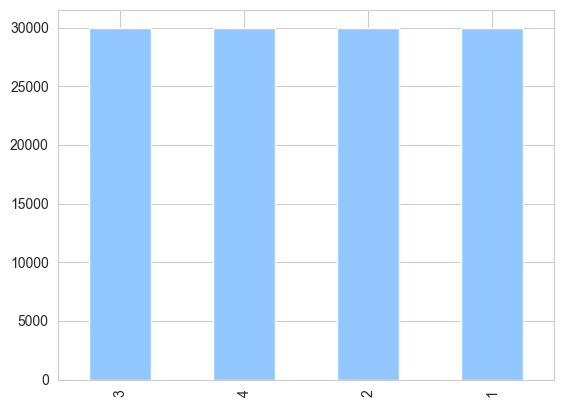

In [15]:
ag_news_train_df['Class Index'].value_counts().plot(kind='bar')

Balanced target

#### Distribution of review lengths

(array([1.4993e+04, 1.8380e+03, 3.4300e+02, 8.3000e+01, 5.0000e+01,
        1.2000e+01, 9.0000e+00, 5.0000e+00, 4.0000e+00, 3.0000e+00]),
 array([  0. ,  57.1, 114.2, 171.3, 228.4, 285.5, 342.6, 399.7, 456.8,
        513.9, 571. ]),
 <BarContainer object of 10 artists>)

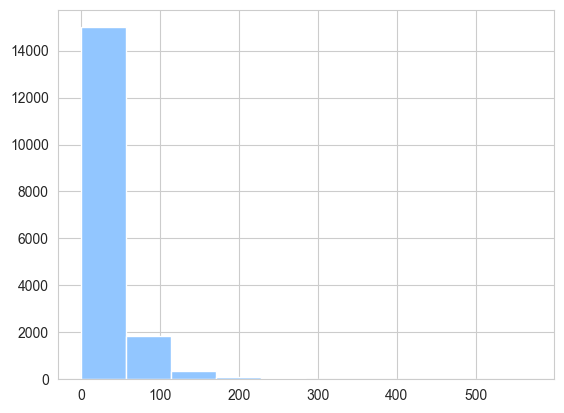

In [16]:
plt.hist(amazon_reviews_df.cleaned_review_length)

#### Distribution of the news article lengths

(array([4.8100e+03, 6.7638e+04, 4.1664e+04, 4.2770e+03, 1.0700e+03,
        2.9800e+02, 9.3000e+01, 9.0000e+01, 2.9000e+01, 3.1000e+01]),
 array([  6. , 103.9, 201.8, 299.7, 397.6, 495.5, 593.4, 691.3, 789.2,
        887.1, 985. ]),
 <BarContainer object of 10 artists>)

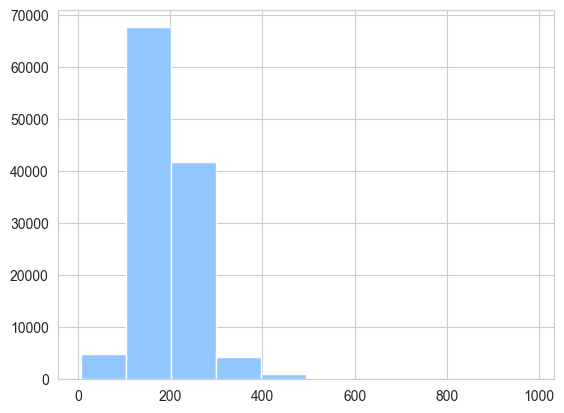

In [17]:
plt.hist(ag_news_train_df.Description.str.len())

In [18]:
ag_news_train_df.isna().any()

Class Index    False
Title          False
Description    False
dtype: bool

#### Removing NaNs

In [19]:
amazon_reviews_df.dropna(inplace=True)

### Splitting amazon reviews into train and test set

In [20]:
X_amazon_reviews = amazon_reviews_df.drop(columns=['sentiments'])
y_amazon_reviews = amazon_reviews_df['sentiments']

In [21]:
X_train_reviews, X_test_reviews, y_train_reviews, y_test_reviews = train_test_split(X_amazon_reviews,
                                                                                   y_amazon_reviews,
                                                                                   random_state=42,
                                                                                   test_size=0.2)

In [22]:
X_train_reviews, X_valid_reviews, y_train_reviews, y_valid_reviews = train_test_split(X_train_reviews,
                                                                                     y_train_reviews,
                                                                                     random_state=42,
                                                                                     test_size = 0.25)

### Splitting ag news into X and y's

Merging Title and Description into one field, "Text"

In [23]:
ag_news_train_df['Text'] = ag_news_train_df[['Title', 'Description']].agg(' '.join,axis=1)
ag_news_test_df['Text'] = ag_news_test_df[['Title', 'Description']].agg(' '.join,axis=1)

In [24]:
ag_news_train_df['Text']

0         Wall St. Bears Claw Back Into the Black (Reute...
1         Carlyle Looks Toward Commercial Aerospace (Reu...
2         Oil and Economy Cloud Stocks' Outlook (Reuters...
3         Iraq Halts Oil Exports from Main Southern Pipe...
4         Oil prices soar to all-time record, posing new...
                                ...                        
119995    Pakistan's Musharraf Says Won't Quit as Army C...
119996    Renteria signing a top-shelf deal Red Sox gene...
119997    Saban not going to Dolphins yet The Miami Dolp...
119998    Today's NFL games PITTSBURGH at NY GIANTS Time...
119999    Nets get Carter from Raptors INDIANAPOLIS -- A...
Name: Text, Length: 120000, dtype: object

In [25]:
X_train_news = ag_news_train_df['Text']
y_train_news = ag_news_train_df['Class Index']

X_test_news = ag_news_test_df['Text']
y_test_news = ag_news_test_df['Class Index']

In [26]:
X_train_news, X_valid_news, y_train_news, y_valid_news = train_test_split(X_train_news,
                                                                          y_train_news,
                                                                          random_state=42,
                                                                          test_size = 0.25)

## Naive feature extraction

### Uni-Bigram vectorizer

Because documents are quite short on average, we used the uni-bigram vectorizer (contains both unigrams and bigrams)

Following pieces of code were taken from Sklearn's text feature extraction tutorial. (https://scikit-learn.org/stable/modules/feature_extraction.html)

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

In [28]:
bigram_vectorizer = CountVectorizer(ngram_range=(1,2), token_pattern=r'\b\w+\b', min_df=1)

In [29]:
start = time.time()
X_train_reviews_tr = bigram_vectorizer.fit_transform(X_train_reviews.cleaned_review)
X_valid_reviews_tr = bigram_vectorizer.transform(X_valid_reviews.cleaned_review)
X_test_reviews_tr = bigram_vectorizer.transform(X_test_reviews.cleaned_review)
end = time.time()
feature_extraction_time_reviews = end-start

In [30]:
bigram_vectorizer.get_feature_names_out()

array(['a', 'a bit', 'a bunch', ..., 'zoom while', 'zooms', 'zooms down'],
      dtype=object)

In [31]:
start = time.time()
X_train_news_tr = bigram_vectorizer.fit_transform(X_train_news)
X_valid_news_tr = bigram_vectorizer.transform(X_valid_news)
X_test_news_tr = bigram_vectorizer.transform(X_test_news)
end=time.time()
feature_extraction_time_news = end-start

## Training shallow models

Balanced accuracy score is used to macro average across classes.

For hyperparam tuning only a half of training data will be used for performance reasons.

In [32]:
np.random.seed(42)
reviews_train_idx = np.random.choice(y_train_reviews.shape[0], 
                                     replace=False, size=y_train_reviews.shape[0]//2)
news_train_idx = np.random.choice(y_train_news.shape[0], 
                                     replace=False, size=y_train_news.shape[0]//8)

In [33]:
X_train_reviews_half = X_train_reviews_tr[reviews_train_idx,:]
y_train_reviews_half = y_train_reviews.iloc[reviews_train_idx]

X_train_news_16th = X_train_news_tr[news_train_idx,:]
y_train_news_16th = y_train_news.iloc[news_train_idx]

X_train_news_8th = X_train_news_tr[news_train_idx,:]
y_train_news_8th = y_train_news.iloc[news_train_idx]

#### Checking if models are saved

In [34]:
best_model_nn_reviews_is_saved = os.path.exists('models/best_model_nn_reviews.sav')
best_model_nn_news_is_saved = os.path.exists('models/best_model_nn_news.sav')
best_model_svm_reviews_is_saved = os.path.exists('models/best_model_svm_reviews.sav')
best_model_svm_news_is_saved = os.path.exists('models/best_model_svm_news.sav')

train_time_nn_reviews = 1262.204321861267
train_time_nn_news = 15825.467003107071
train_time_svm_reviews = 78.65971994400024
train_time_svm_news = 7950.114312410355

### Shallow NN (One layer perceptron)

#### Reviews dataset

In [93]:
available_activations = ['relu', 'logistic', 'tanh']
available_solvers = ['adam', 'lbfgs']
def objective(trial: optuna.trial.Trial):
    size_of_hidden_layer = trial.suggest_int('size_of_hidden_layer', 10, 100)
    alpha = trial.suggest_float('alpha', 0.0001, 0.001)
    activation = trial.suggest_categorical('activation', 
                                           choices=available_activations)
    solver = trial.suggest_categorical('solver', 
                                           choices=available_solvers)
    
    print(f"Trying: {size_of_hidden_layer}, {alpha}, {activation}, {solver}")
    model = MLPClassifier(hidden_layer_sizes=tuple([size_of_hidden_layer]),
                          alpha=alpha,
                          activation = activation,
                          max_iter=20,
                          solver=solver,
                          verbose=True,
                          learning_rate='adaptive',
                          random_state=42)
    model.fit(X_train_reviews_half, y_train_reviews_half)
    y_pred_probas = model.predict_proba(X_valid_reviews_tr)
    return log_loss(y_valid_reviews, y_pred_probas)


if not best_model_nn_reviews_is_saved:
    study_nn_reviews = optuna.create_study(direction='minimize')
    # optuna.logging.set_verbosity(optuna.logging.DEBUG)
    study_nn_reviews.optimize(objective, n_trials=10,show_progress_bar=True,n_jobs=-1)

    study_nn_reviews.best_params

{'size_of_hidden_layer': 85,
 'alpha': 0.00045434026867030927,
 'activation': 'logistic',
 'solver': 'adam'}

In [94]:
if not best_model_nn_reviews_is_saved:
    best_model_nn_reviews = MLPClassifier(hidden_layer_sizes=(85,), 
                              alpha=0.00045434026867030927,
                              solver='adam',
                              activation='logistic',
                                random_state=42,
                               learning_rate='adaptive',
                               verbose=True,
                              max_iter=50,
                          )
    start=time.time()
    best_model_nn_reviews.fit(X_train_reviews_tr, y_train_reviews)
    end=time.time()

    print("It took ", end-start, "seconds")
    train_time_nn_reviews = end-start

In [95]:
if not best_model_nn_reviews_is_saved:
    pickle.dump(best_model_nn_reviews, open('models/best_model_nn_reviews.sav', 'wb'))
    best_model_nn_reviews_is_saved = True
else:
    best_model_nn_reviews=pickle.load(open('models/best_model_nn_reviews.sav', 'rb'))

D:\virtual_envs\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
D:\virtual_envs\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [157]:
start = time.time()
y_preds_nn_reviews = best_model_nn_reviews.predict(X_test_reviews_tr)
end = time.time()
test_time_nn_reviews = end-start
balanced_acc_shallow_nn_reviews = balanced_accuracy_score(y_test_reviews, y_preds_nn_reviews)

In [158]:
balanced_acc_shallow_nn_reviews

0.7861248313512093

Reviews:
Baseline of shallow NNs (balanced accuracy = average of recalls for each class): __0.758__

#### News dataset

In [98]:
available_activations = ['relu', 'logistic', 'tanh']
available_solvers = ['adam', 'lbfgs']
def objective(trial: optuna.trial.Trial):
    size_of_hidden_layer = trial.suggest_int('size_of_hidden_layer', 10, 100)
    alpha = trial.suggest_float('alpha', 0.0001, 0.001)
    activation = trial.suggest_categorical('activation', 
                                           choices=available_activations)
    solver = trial.suggest_categorical('solver', 
                                           choices=available_solvers)
    
    print(f"Trying: {size_of_hidden_layer}, {alpha}, {activation}, {solver}")
    model = MLPClassifier(hidden_layer_sizes=tuple([size_of_hidden_layer]),
                          alpha=alpha,
                          activation = activation,
                          max_iter=20,
                          solver=solver,
                          verbose=True,
                          learning_rate='adaptive',
                          random_state=42)
    model.fit(X_train_news_16th, y_train_news_16th)
    y_pred_probas = model.predict_proba(X_valid_news_tr)
    return log_loss(y_valid_news, y_pred_probas)

if not best_model_nn_news_is_saved:
    study_nn_news = optuna.create_study(direction='minimize')
    # optuna.logging.set_verbosity(optuna.logging.DEBUG)
    study_nn_news.optimize(objective, n_trials=10,show_progress_bar=True,n_jobs=2)

    study_nn_news.best_params

best value: 0.3686714944409208 (log loss)
 
best params:
{'size_of_hidden_layer': 34,
 'alpha': 0.0004980605929484772,
 'activation': 'tanh',
 'solver': 'adam'}
 
last:
{'size_of_hidden_layer': 28, 'alpha': 0.0009033187102132166, 'activation': 'tanh', 'solver': 'adam'}

In [99]:
if not best_model_nn_news_is_saved:
    start=time.time()
    best_model_nn_news = MLPClassifier(hidden_layer_sizes=(34,),
                              alpha=0.0004980605929484772,
                              solver='adam',
                              activation='tanh',
                                random_state=42,
                               learning_rate='adaptive',
                               verbose=True,
                              max_iter=20,
                          )
    best_model_nn_news.fit(X_train_news_tr, y_train_news)
    end=time.time()

    print("It took ", end-start, "seconds")
    train_time_nn_news = end-start

In [100]:
if not best_model_nn_news_is_saved:
    pickle.dump(best_model_nn_news, open('models/best_model_nn_news.sav', 'wb'))
    best_model_nn_news_is_saved = True
else:
    best_model_nn_news=pickle.load(open('models/best_model_nn_news.sav', 'rb'))

In [159]:
start = time.time()
y_preds_nn_news = best_model_nn_news.predict(X_test_news_tr)
end = time.time()
test_time_nn_news = end-start
balanced_acc_shallow_nn_news = balanced_accuracy_score(y_test_news, y_preds_nn_news)

In [160]:
balanced_acc_shallow_nn_news

0.9096052631578948

News Baseline of shallow NNs (balanced accuracy = average of recalls for each class): __0.90__

### SVM

#### Reviews dataset

In [105]:
model_reviews = SVC(probability=True, random_state=42)
param_grid_reviews = {'C': [0.1, 1, 10], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel':['poly', 'sigmoid', 'linear', 'rbf']} 

if not best_model_svm_reviews_is_saved:
    randomized_search_reviews = RandomizedSearchCV(model_reviews, param_grid_reviews, refit = True, verbose = 3, random_state=42)
    randomized_search_reviews.fit(X_train_reviews_half, y_train_reviews_half)

In [106]:
# randomized_search_reviews.best_params_

Best params were Linear kernel, gamma=0.001 and C=10.

In [107]:
# randomized_search_reviews.best_score_

In [108]:
if not best_model_svm_reviews_is_saved:
    start=time.time()
    best_model_svm_reviews =  SVC(probability=True, random_state=42, kernel='linear', gamma=0.001, C=10)
    best_model_svm_reviews.fit(X_train_reviews_tr, y_train_reviews)
    end=time.time()

    print("It took ", end-start, "seconds")
    train_time_svm_reviews = end-start

In [109]:
if not best_model_svm_reviews_is_saved:
    pickle.dump(best_model_svm_reviews, open('models/best_model_svm_reviews.sav', 'wb'))
    best_model_svm_reviews_is_saved = True
else:
    best_model_svm_reviews=pickle.load(open('models/best_model_svm_reviews.sav', 'rb'))

In [163]:
start = time.time()
y_preds_svm_reviews = best_model_svm_reviews.predict(X_test_reviews_tr)
end = time.time()
test_time_svm_reviews = end-start
balanced_acc_svm_reviews = balanced_accuracy_score(y_test_reviews, y_preds_svm_reviews)

In [164]:
balanced_acc_svm_reviews

0.802734774339105

Balanced accuracy for reviews dataset with SVM: __0.78__

#### News dataset

In [112]:
model = SVC(probability=True, random_state=42)
param_grid = {'C': [0.1, 1, 10], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel':['poly', 'sigmoid', 'linear', 'rbf']} 

if not best_model_svm_news_is_saved:
    randomized = RandomizedSearchCV(model, param_grid, refit = True, verbose = 3, random_state=42)
    randomized.fit(X_train_news_16th, y_train_news_16th)

In [113]:
# randomized.best_params_

Best params were linear kernel, gamma = 0.001, C=10

In [114]:
# randomized.best_score_

In [115]:

if not best_model_svm_news_is_saved:
    start=time.time()
    best_model_svm_news = SVC(kernel='linear', gamma=0.001, C=10, verbose=True, random_state=42)
    best_model_svm_news.fit(X_train_news_tr, y_train_news)
    end=time.time()

    print("It took ", end-start, "seconds")
    train_time_svm_news = end-start

In [118]:
if not best_model_svm_news_is_saved:
    pickle.dump(best_model_svm_news, open('models/best_model_svm_news.sav', 'wb'))
    print('dumped')
    best_model_nn_news_is_saved = True
else:
   best_model_svm_news=pickle.load(open('models/best_model_svm_news.sav', 'rb'))

In [165]:
start = time.time()
y_preds_svm_news = best_model_svm_news.predict(X_test_news_tr)
end = time.time()
test_time_svm_news = end-start

balanced_acc_svm_news = balanced_accuracy_score(y_test_news, y_preds_svm_news)

In [120]:
balanced_acc_svm_news

0.9119000794033292

Balanced accuracy for news dataset with SVM: __0.912__

### Creating result dataframes

In [156]:
y_valid_reviews.shape

(4577,)

In [180]:
conf_mat_nn_reviews = pd.crosstab(y_test_reviews, y_preds_nn_reviews, rownames=['Actual'], colnames=['Predicted'])

In [198]:
nn_reviews_results = classification_report(y_test_reviews, y_preds_nn_reviews,output_dict=True)
nn_news_results = classification_report(y_test_news, y_preds_nn_news,output_dict=True)
svm_reviews_results = classification_report(y_test_reviews, y_preds_svm_reviews,output_dict=True)
svm_news_results = classification_report(y_test_news, y_preds_svm_news,output_dict=True)

In [233]:
nn_reviews_results['train_time'] = train_time_nn_reviews
nn_news_results['train_time'] = train_time_nn_news
svm_reviews_results['train_time'] = train_time_svm_reviews
svm_news_results['train_time'] = train_time_svm_news

nn_reviews_results['test_time'] = test_time_nn_reviews
nn_news_results['test_time'] = test_time_nn_news
svm_reviews_results['test_time'] = test_time_svm_reviews
svm_news_results['test_time'] = test_time_svm_news

nn_reviews_results['feature_extraction_time'] = feature_extraction_time_reviews
nn_news_results['feature_extraction_time'] = feature_extraction_time_news

NameError: name 'test_time_svm_news' is not defined

In [230]:
nn_reviews_results_df = pd.DataFrame.from_dict(nn_reviews_results)
nn_news_results_df = pd.DataFrame.from_dict(nn_news_results)
svm_reviews_results_df = pd.DataFrame.from_dict(svm_reviews_results)
svm_news_results_df = pd.DataFrame.from_dict(svm_news_results)

In [232]:
nn_reviews_results_df.to_csv('results/baselines/nn_reviews_baseline.csv')
nn_news_results_df.to_csv('results/baselines/nn_news_baseline.csv')
svm_reviews_results_df.to_csv('results/baselines/svm_reviews_baseline.csv')
svm_news_results_df.to_csv('results/baselines/svm_news_baseline.csv')


## Data augmentation

Amazon reviews dataset is augmented.

In [35]:
import nltk
import random
from nltk.corpus import wordnet

In [36]:
# Download the necessary NLTK resources
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Radoslav Gajanin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to C:\Users\Radoslav
[nltk_data]     Gajanin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [37]:
# Define a function to replace a percentage of nouns with their synonyms
def replace_noun_synonyms(text, p=0.2):
    words = nltk.word_tokenize(text)
    tagged_words = nltk.pos_tag(words) # Words tagged with NN are nouns
    new_words = []
    for word, tag in tagged_words:
        if tag == 'NN' or tag.startswith('VB') and random.random() < p:
            synonyms = wordnet.synsets(word)
            synonyms = [x for x in synonyms if x.lemmas()[0].name() != word] # synonyms only different from the original word
            if synonyms:
                new_word = synonyms[0].lemmas()[0].name()
                new_words.append(new_word)
            else:
                new_words.append(word)
        else:
            new_words.append(word)
    return ' '.join(new_words)

In [38]:
# Select 80% of the reviews and apply the noun synonym replacement
X_train_augmented = X_train_reviews.copy()
y_train_augmented = y_train_reviews.copy()
#augmented_indices = train_aug_df.sample(frac=1, random_state=42).index
random.seed(42)
X_train_augmented.loc[:, 'cleaned_review'] = X_train_augmented.loc[:, 'cleaned_review'].apply(replace_noun_synonyms)

In [39]:
# Print the first few rows of the augmented training data
i = 2

print(X_train_augmented['cleaned_review'].iloc[i])
print(X_train_reviews['cleaned_review'].iloc[i])

just like describe very pleased we also had an topic with not getting our first loudspeaker reach out to the caller and they be so willing to work with us to get replacement sent out ASAP would highly recommend this caller and merchandise without reluctance
just like described very pleased we also had an issue with not getting our first speaker reached out to the company and they were so willing to work with us to get replacement sent out asap would highly recommend this company and product without hesitation 


In [42]:
X_train_augmented

,cleaned_review,cleaned_review_length,review_score
11652,iodine do beloved this merchandise but bought ...,19,4.0
7240,this shiner plant very well and has very long ...,16,5.0
16483,just like describe very pleased we also had an...,45,5.0
13353,our class old Son asked for this headset for h...,44,5.0
6024,nice look shiner beautiful colors and comforta...,69,5.0
...,...,...,...
10086,there great headset,3,5.0
7496,iodine love the fact that there are no batteri...,13,1.0
12107,great sound timbre at great monetary_value kno...,13,5.0
13718,iodine bought this for my class old he go thro...,30,4.0


In [47]:
X_train_reviews_augmented= pd.concat([X_train_reviews, X_train_augmented])
y_train_reviews_augmented= pd.concat([y_train_reviews, y_train_augmented])


X_train_reviews_augmented.to_csv('data/X_train_reviews_augmented.csv')
y_train_reviews_augmented.to_csv('data/y_train_reviews_augmented.csv')

(20802, 3)